In [3]:
import json
path = "openimages/jsonl/sft_with_local_source_image_path.jsonl"
data_all = []
with open(path, 'r', encoding='utf-8') as f:
    for line in f:
        data_all.append(json.loads(line))

In [4]:
data = data_all[854]  # 查看第一条数据

In [5]:
import PIL.Image as Image
tmp = Image.open(data["local_input_image"])
tmp1 = Image.open(data["output_image"])

In [6]:
data

{'open_image_input_url': 'https://farm4.staticflickr.com/3434/3732153854_5e0837cbe0_o.jpg',
 'text': 'Apply a subtle, fine-grained analog film noise effect across the entire image, slightly desaturate the colors to evoke a vintage aesthetic, and introduce a gentle warm sepia tone to the highlights while deepening the shadows, maintaining the dramatic spotlight effect on the gummy figures.',
 'output_image': 'openimages/edited/sft/1239.png',
 'edit_type': 'Add film grain or vintage filter',
 'summarized_text': 'Add subtle analog film noise, desaturate colors, and add warm sepia highlights with deepened shadows.',
 'local_input_image': 'openimages/source/train_0/000aadc350c9ae93.jpg'}

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(tmp)
plt.title("Input Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(tmp1)
plt.title("Edited Image")
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [8]:
# 找到 data_all 中 'output_image' 包含 'positive-edit/15.png' 的索引
indices = [i for i, d in enumerate(data_all) if 'positive-edit/15.png' in d.get('output_image', '')]
print("Matching indices:", indices)

Matching indices: []


In [9]:
from collections import Counter

# 统计 data_all 中所有条目的 edit_type
edit_types = [d.get('edit_type') for d in data_all if 'edit_type' in d]
edit_type_counts = Counter(edit_types)
edit_type_all = []
print("Edit type counts:")
for edit_type, count in edit_type_counts.items():
    print(f"{edit_type}: {count}")
    edit_type_all.append(edit_type)

Edit type counts:
Remove an existing object: 15109
Change overall color tone (warm ↔ cool): 14745
Add new scene context/background: 14829
Replace one object category with another: 14547
Add a new object to the scene: 14187
Photo to cartoon/sketch/comic: 12735
Add film grain or vintage filter: 15443
Change the size/shape/orientation of an object: 10787
Outpainting (extend canvas beyond boundaries): 12402
Change an object's attribute (e.g., color/material): 13813
Change weather conditions (sunny/rainy/snowy): 11992
Strong artistic style transfer (e.g., Van Gogh/anime/etc.): 15284
Adjust global lighting (golden hour/fluorescent): 12432
Modern ↔ historical style/look: 14856
Apply seasonal transformation (summer ↔ winter): 13438
Relocate an object (change its position/spatial relation): 6612
Zoom in: 13729
Sticker-ify the person with bold outline and white border: 1422
Add/Remove/Replace Accessories (glasses, hats, jewelry, masks): 1597
Line-art ink sketch of the person: 1482
Funko-Pop–styl

In [10]:
etype = edit_type_all[15]

Relocate an object (change its position/spatial relation)
Example data:
{'open_image_input_url': 'https://c1.staticflickr.com/7/6001/5991999844_3148a6a962_o.jpg', 'text': "Relocate the red and white football from its current position near the player's left foot to a new position approximately 1-2 feet directly in front of his right foot, ensuring the ball's shadow is realistically cast and the surrounding grass texture is seamlessly integrated to maintain natural lighting and perspective.", 'output_image': 'openimages/edited/sft/44.png', 'edit_type': 'Relocate an object (change its position/spatial relation)', 'summarized_text': 'Place the red and white football 1-2 feet in front of his right foot, with realistic shadow and grass texture.', 'local_input_image': 'openimages/source/train_0/0005c78e30d1e388.jpg'}


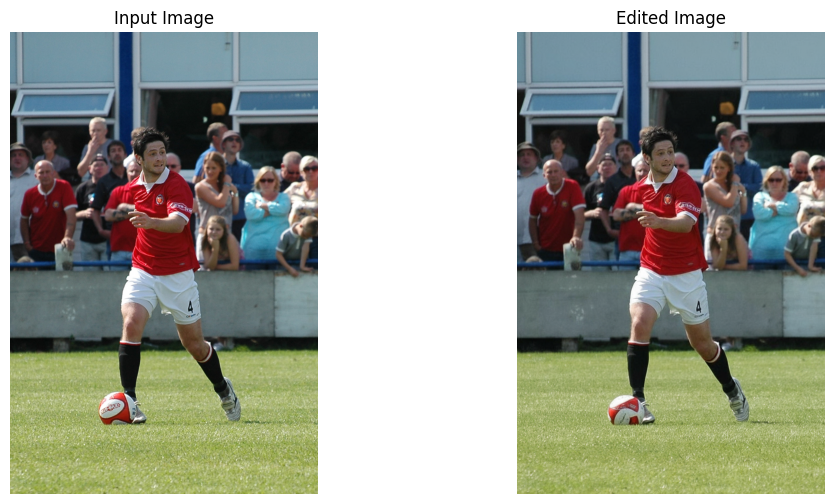

In [12]:

print(etype)
filtered_data = [d for d in data_all if d.get('edit_type') == etype]
i = 200
n = 0
if filtered_data:
    import os
    import PIL.Image as Image
    import matplotlib.pyplot as plt

    found = False
    for example in filtered_data:
        example['output_image'] = example['output_image'].replace('images/positive-edit','openimages/edited/sft/images/positive-edit')
        if os.path.exists(example["local_input_image"]) and os.path.exists(example["output_image"]):
            n+=1
            if n < i :
                pass
            print("Example data:")
            print(example)
            
            # 加载图像
            input_img = Image.open(example["local_input_image"])
            output_img = Image.open(example["output_image"])

            # 显示图像
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            plt.imshow(input_img)
            plt.title("Input Image")
            plt.axis('off')
            plt.subplot(1,2,2)
            plt.imshow(output_img)
            plt.title("Edited Image")
            plt.axis('off')
            plt.show()
            found = True
            break
        else:
            print(f"Skipping example: Input {example['local_input_image']} or Output {example['output_image']} does not exist.")

    if not found:
        print("No valid example found with existing images.")
else:
    print("No data found for this edit_type")

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen3-32B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [2]:

# prepare the model input
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True # Switches between thinking and non-thinking modes. Default is True.
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# conduct text completion
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=32768
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:", thinking_content)
print("content:", content)


thinking content: <think>
Okay, the user asked for a short introduction to large language models. Let me start by breaking down what they might need. They probably want a concise overview without too much jargon. First, I should define what a large language model is. Maybe mention they're a type of AI that processes and generates human-like text. Then, I need to explain how they work—transformer architecture, self-attention mechanisms, and training on vast datasets. It's important to highlight their applications like translation, summarization, and chatbots. Also, touch on their capabilities and limitations, such as data dependency and potential biases. Keep it simple and structured. Let me check if I missed any key points. Oh, maybe mention examples like GPT or BERT. Make sure it's all in plain language. Alright, that should cover the essentials without overwhelming the user.
</think>
content: A **large language model (LLM)** is a type of artificial intelligence trained to understand,

In [ ]:
# Heuristically detect add/remove-object edits and score confidence.
import re

ADD_KEYWORDS = [
    "add",
    "add in",
    "include",
    "insert",
    "place",
    "put",
    "bring",
    "introduce",
    "drop in",
    "drop",
    "set",
    "spawn",
    "create",
    "attach",
    "paint",
    "draw",
    "appear"
]

REMOVE_KEYWORDS = [
    "remove",
    "delete",
    "eliminate",
    "erase",
    "take away",
    "take out",
    "get rid of",
    "without",
    "hide",
    "cover",
    "clear",
    "strip away",
    "strip",
    "crop out"
]

ARTICLES = {"a", "an", "the", "this", "that", "these", "those", "another", "one", "two", "three", "some"}
STOP_TOKENS = {
    "to", "into", "onto", "with", "while", "that", "which", "so", "and", "but", "before", "after",
    "near", "next", "beside", "by", "from", "because", "ensuring", "ensure", "keep", "keeping",
    "maintaining", "make", "makes", "making", "for", "when", "where", "using", "use", "on", "in",
    "at", "of"
}

def _first_keyword_span(text, keywords):
    best = None
    for kw in keywords:
        idx = text.find(kw)
        if idx != -1:
            span = (idx, idx + len(kw))
            if best is None or idx < best[0]:
                best = span
    return best

def _extract_object_phrase(original, start_idx):
    remainder = original[start_idx:].strip()
    tokens = remainder.split()
    phrase_tokens = []
    for token in tokens:
        stripped = token.strip(",.;:!?")
        lower = stripped.lower()
        if not stripped:
            continue
        if not phrase_tokens and lower in ARTICLES:
            continue
        if lower in STOP_TOKENS:
            break
        phrase_tokens.append(stripped)
        if len(phrase_tokens) >= 6:
            break
    candidate = " ".join(phrase_tokens).strip()
    return candidate or None

def _classify_object_edit(entry):
    text = (entry.get("summarized_text") or entry.get("text") or "").strip()
    if not text:
        return "other", None, 0
    lower = text.lower()
    add_hits = [kw for kw in ADD_KEYWORDS if kw in lower]
    remove_hits = [kw for kw in REMOVE_KEYWORDS if kw in lower]

    if not add_hits and not remove_hits:
        return "other", None, 0

    if add_hits and not remove_hits:
        action = "add"
    elif remove_hits and not add_hits:
        action = "remove"
    else:
        def _first_idx(keywords):
            indices = [lower.find(kw) for kw in keywords if kw in lower]
            return min(indices) if indices else float("inf")
        action = "add" if _first_idx(ADD_KEYWORDS) <= _first_idx(REMOVE_KEYWORDS) else "remove"

    span = _first_keyword_span(lower, ADD_KEYWORDS if action == "add" else REMOVE_KEYWORDS)
    object_name = None
    if span:
        object_name = _extract_object_phrase(text, span[1])

    keyword_hits = add_hits if action == "add" else remove_hits
    confidence = min(10, max(3, 4 + len(keyword_hits) * 2 + (2 if object_name else 0)))
    return action, object_name, confidence

object_edit_judgements = []
for idx, entry in enumerate(data_all):
    action, object_name, score = _classify_object_edit(entry)
    object_edit_judgements.append({
        "index": idx,
        "edit_type": entry.get("edit_type"),
        "action": action,
        "object_name": object_name,
        "confidence": score
    })

filtered_judgements = [j for j in object_edit_judgements if j["action"] != "other"]
print(f"Detected {len(filtered_judgements)} add/remove-object instructions out of {len(object_edit_judgements)} total entries.")
print("Sample results:")
for example in filtered_judgements[:5]:
    print(example)
